# Total COVID-19 deaths for different countries

Script produced by [Laurent Lessard](https://laurentlessard.com)

---

### Import data from JHU CSSE

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mpl.rcParams['figure.dpi'] = 120

url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
df_raw = pd.read_csv(url)

### Reformat data into convenient form

In [2]:
colnames = df_raw.columns

# aggregate by region
df = df_raw.pivot_table(index='Country/Region',values=colnames[4:],aggfunc=sum)

# make countries columns rather than rows
df = df.T

# make the index a datetime object
df = df.reindex( pd.to_datetime(df.index) )

# sort the dates/times
df.sort_index(inplace=True)

# record the latest date
latest_date = df.index[-1].strftime("%a %b %d, %Y")
print(latest_date)

Mon Oct 26, 2020


### List of countries with the most deaths

In [3]:
deaths_sorted = df.iloc[-1].sort_values(ascending=False)
deaths_sorted.head(20)

Country/Region
US                225706
Brazil            157397
India             119502
Mexico             89171
United Kingdom     45088
Italy              37479
France             35052
Spain              35031
Peru               34149
Iran               32953
Colombia           30348
Argentina          29301
Russia             26092
South Africa       19008
Chile              14003
Indonesia          13411
Ecuador            12573
Belgium            10810
Iraq               10671
Germany            10091
Name: 2020-10-26 00:00:00, dtype: int64

### List of countries with the most daily deaths

In [4]:
daily_deaths_sorted = df.diff().iloc[-1].sort_values(ascending=False)
daily_deaths_sorted.head(15)

Country/Region
Brazil            494.0
India             488.0
US                477.0
Argentina         405.0
France            379.0
Colombia          348.0
Iran              337.0
Spain             279.0
Mexico            247.0
Russia            217.0
Tunisia           164.0
Czechia           164.0
Italy             141.0
Indonesia         112.0
United Kingdom    102.0
Name: 2020-10-26 00:00:00, dtype: float64

### Plot shifted death toll for selected countries

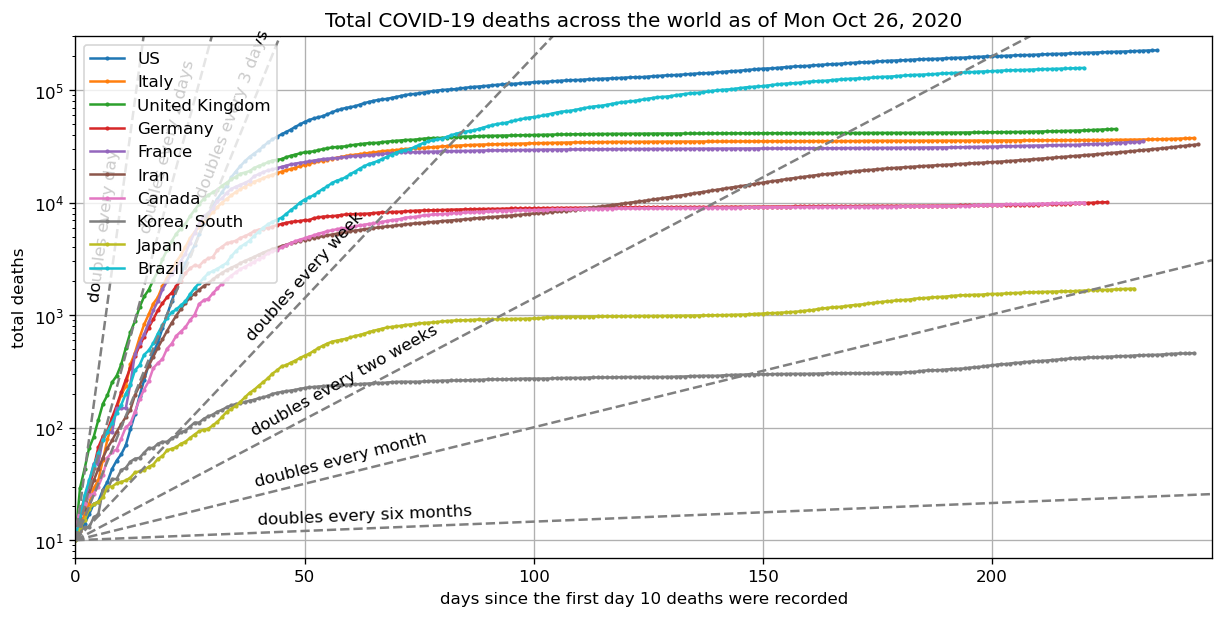

In [5]:
# function that shifts the data so everything starts from first min_deaths
def shift_data( countries, min_deaths ):
    shifted_data = []
    for (c,data) in df[countries].items():
        shifted_data.append( data[data >= min_deaths].reset_index(drop=True) )
    return shifted_data

# selected countries
countries = ['US','Italy','United Kingdom','Germany','France','Iran', 'Canada', 'Korea, South', 'Japan', 'Brazil']
# countries = deaths_sorted[:10].index
min_deaths = 10

# shift data so that index corresponds to days since min_death deaths.
shifted_data = shift_data( countries, min_deaths )
data_len = max([len(dat) for dat in shifted_data])

xmax = data_len + 2

# merge into a single dataframe
dfx = pd.concat( shifted_data, axis=1 )

# make plot
ax = dfx.plot(title="Total COVID-19 deaths across the world as of %s" % latest_date, logy=True, figsize=(10,5), grid=True, marker='.', markersize=3)
ax.legend(loc="upper left")
ax.set_xlabel("days since the first day %g deaths were recorded" % min_deaths )
ax.set_ylabel("total deaths")
ax.set_ylim(min_deaths*.7,3e5)
ax.set_xlim(0,xmax)

# draw doubling lines (doubling every d days)
dvals = [1,2,3,7,14,30,182]    # values of doubling lines to draw (d)
dtxt = ["day", "2 days", "3 days", "week", "two weeks", "month", "six months"]
tloc = [7,18,30,40,40,40,40] # x-coordinate of text labels
for i,d in enumerate(dvals):
    tx = tloc[i]
    ty = min_deaths*(2**(tx/d))
    angle = np.arctan(ty/d * np.log(2))
    angle_screen = ax.transData.transform_angles(np.array([angle,]),np.array([[tx,ty]]),radians=True)[0]
    y = min_deaths*(2**(xmax/d))
    plt.plot([0,xmax],[min_deaths,y], '--', color='gray')
    ax.annotate("doubles every %s" % dtxt[i], xy=(tx,ty), xytext=(-5*np.sin(angle_screen),5*np.cos(angle_screen)),
                textcoords="offset points", rotation_mode='anchor', rotation=np.rad2deg(angle_screen))

plt.tight_layout(pad=0)
plt.savefig("figures/world_total_deaths_vs_time.png")

### Plot deaths in the past week versus total deaths

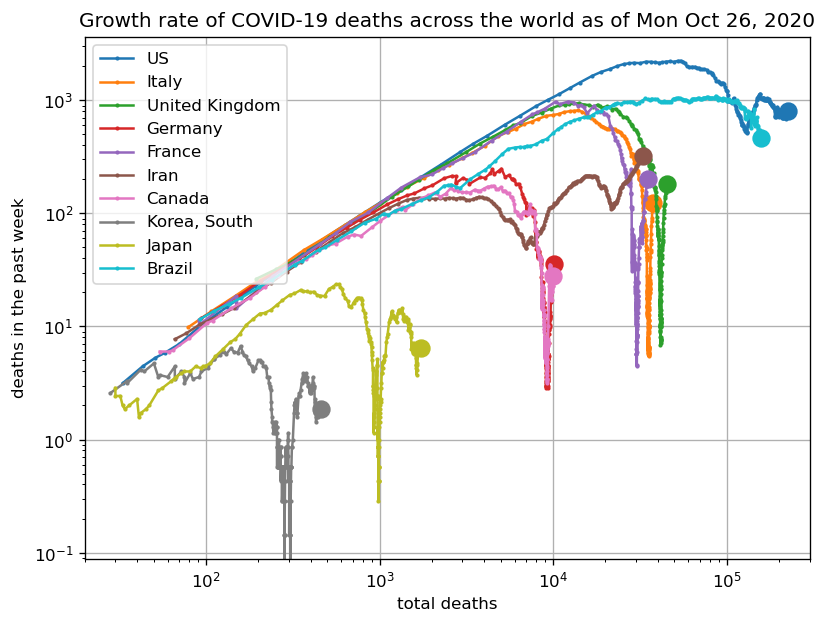

In [6]:
plt.figure(figsize=(7,5))
ax = plt.gca()

for data in shifted_data:
    color = next(ax._get_lines.prop_cycler)['color']
    plt.loglog( data, data.diff().rolling(7).mean(), marker=".", label=data.name, color=color, markersize=3 )
    plt.loglog( data.iloc[-1], data.diff().rolling(7).mean().iloc[-1], marker=".", markersize=20, label=None, color=color )
    
plt.xlabel("total deaths")
plt.ylabel("deaths in the past week")
plt.xlim(20,3e5)
plt.grid()
plt.title("Growth rate of COVID-19 deaths across the world as of %s" % latest_date)
plt.legend()
plt.tight_layout(pad=0)
plt.savefig("figures/world_total_deaths_growth.png")

### Plot the "Ten-Hundred plot" for total deaths
The idea for this plot is due to [Jerry Zhu](https://www.youtube.com/watch?v=NP3ZdQwrL_Q)

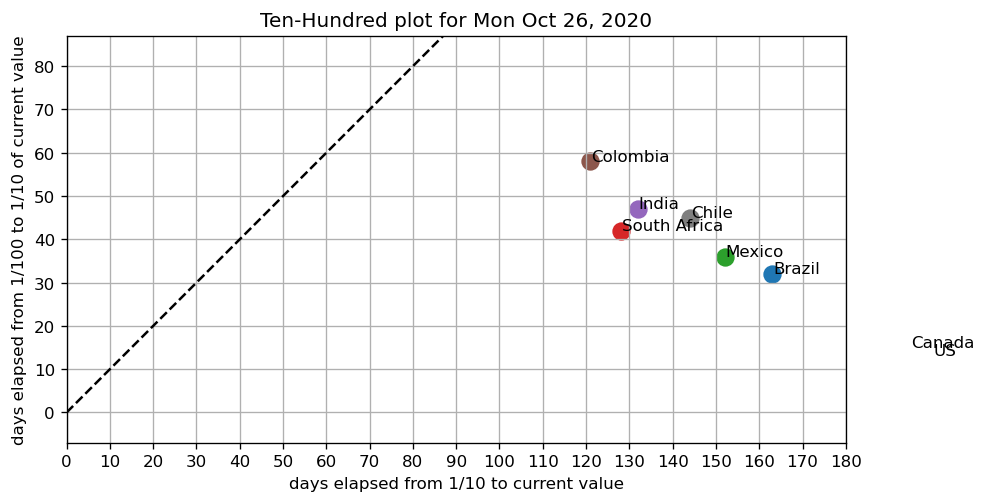

In [7]:
# selected countries (should have >> 100 deaths for the plot to be meaningful)
countries = ['Brazil','US','Mexico','South Africa','India','Colombia','Canada','Chile']
min_deaths = 10

# strip time indices since they don't matter for this plot
df_stripped = df.reset_index(drop=True)

plt.figure(figsize=(8,4))

for country in countries[:]:
    data = df_stripped[country]
    ix_end = data.index[-1]
    ix_10  = data[ data < data.iloc[-1]/10  ].index[-1]
    ix_100 = data[ data < data.iloc[-1]/100 ].index[-1]
    x = ix_end - ix_10
    y = ix_10 - ix_100
    plt.scatter( x, y, marker="o", label=data.name, s=100 )
    plt.text( x+.2, y+.2, country )
plt.plot([0,100],[0,100],'k--')
    
plt.xlabel("days elapsed from 1/10 to current value")
plt.ylabel("days elapsed from 1/100 to 1/10 of current value")
plt.grid()
plt.axis("equal")
plt.xticks(range(0,220,10))
plt.yticks(range(0,100,10))
plt.axis([0,180,0,80])
plt.title("Ten-Hundred plot for %s" % latest_date)
plt.tight_layout(pad=0)
plt.savefig("figures/world_total_deaths_tenhundred.png")

### Plot death rate using heatmap

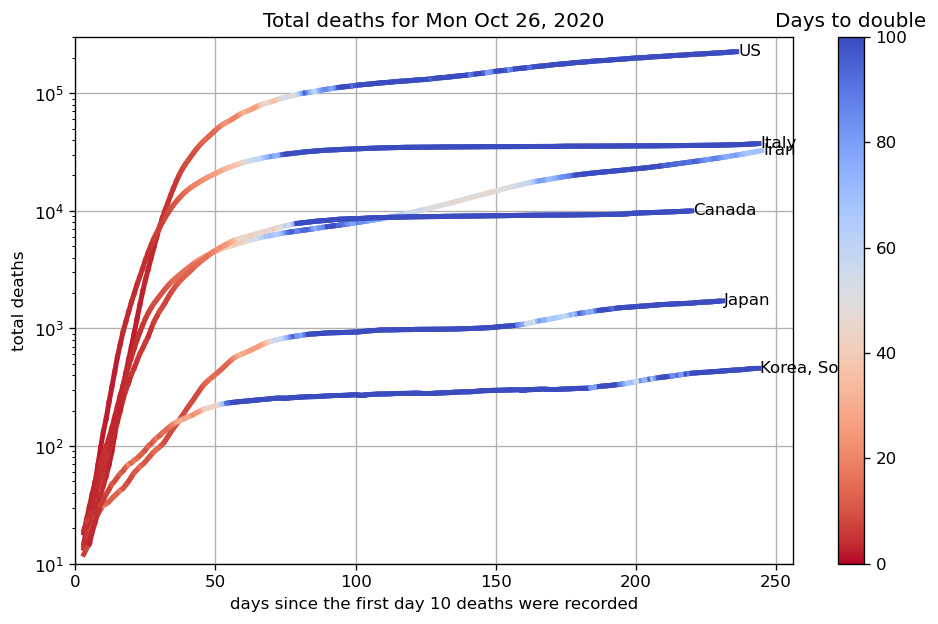

In [8]:
rmin,rmax = 0,100
window=4

countries = ['US','Italy','Iran','Canada','Japan','Korea, South']

# shift data so that index corresponds to days since min_death deaths.
shifted_data = shift_data( countries, min_deaths )
data_len = max([len(dat) for dat in shifted_data])

xmax = data_len + 10

# merge into a single dataframe
dfx = pd.concat( shifted_data, axis=1 )


fig = plt.figure(figsize=(8,5))
cmap = mpl.cm.get_cmap('coolwarm_r')
# cmap = mpl.cm.get_cmap('cool_r')
# cmap = mpl.cm.get_cmap('PuBuGn')
# PuRd BuPu PuBuGn YlGnBu

for country in countries:

    v = dfx[country].rolling(window).mean()
    r = ( np.log(2) / np.log(v).diff() )
    c = (r - rmin)/(rmax-rmin)

    for (i,y) in enumerate(v[:-1]):
        plt.semilogy( [i,i+1], [v[i],v[i+1]], color=cmap(c[i+1]), linewidth=3 )

    ax = plt.gca()
    plt.text( v.dropna().index[-1]+0.5, v.dropna().iloc[-1], country, verticalalignment='center', horizontalalignment='left')

clb = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=rmin, vmax=rmax), cmap=cmap), ax=ax)
clb.ax.set_title('Days to double')

plt.xlim([0,xmax])
plt.ylim([1e1,3e5])
plt.grid()
plt.xlabel("days since the first day %g deaths were recorded" % min_deaths )
plt.ylabel("total deaths")
plt.title("Total deaths for %s" % latest_date)
plt.tight_layout(pad=0)
plt.savefig("figures/world_total_deaths_heatmap.png")

### Plot daily deaths

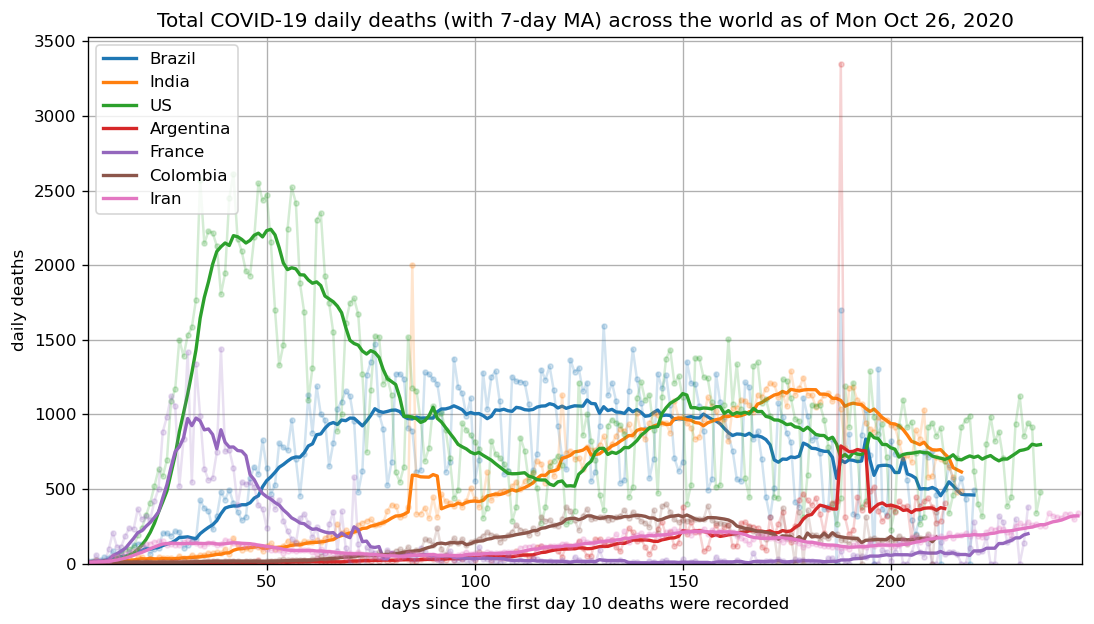

In [9]:
plt.figure(figsize=(9,5))
ax = plt.gca()

# selected countries
# countries = ['US','Italy','Spain','United Kingdom','France','Iran', 'Canada', 'Korea, South', 'Japan']
countries = daily_deaths_sorted[:7].index
min_deaths = 10

# shift data so that index corresponds to days since min_death deaths.
shifted_data = shift_data( countries, min_deaths )
data_len = max([len(dat) for dat in shifted_data])

xmax = data_len


for data in shifted_data:
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot( data.diff(), marker=".", label=None, color=color, alpha=0.2 )
    plt.plot( data.diff().rolling(7).mean(), marker="", label=data.name, color=color, linewidth=2 )

# make plot
ax.set_title("Total COVID-19 daily deaths (with 7-day MA) across the world as of %s" % latest_date)
ax.legend(loc="upper left")
ax.set_xlabel("days since the first day %g deaths were recorded" % min_deaths )
ax.set_ylabel("daily deaths")
ax.grid()
ax.set_xlim(7,xmax)
ax.set_ylim(ymin=0)
    
plt.tight_layout(pad=0)
plt.savefig("figures/world_daily_deaths_vs_time.png")

### Total deaths on a linear scale

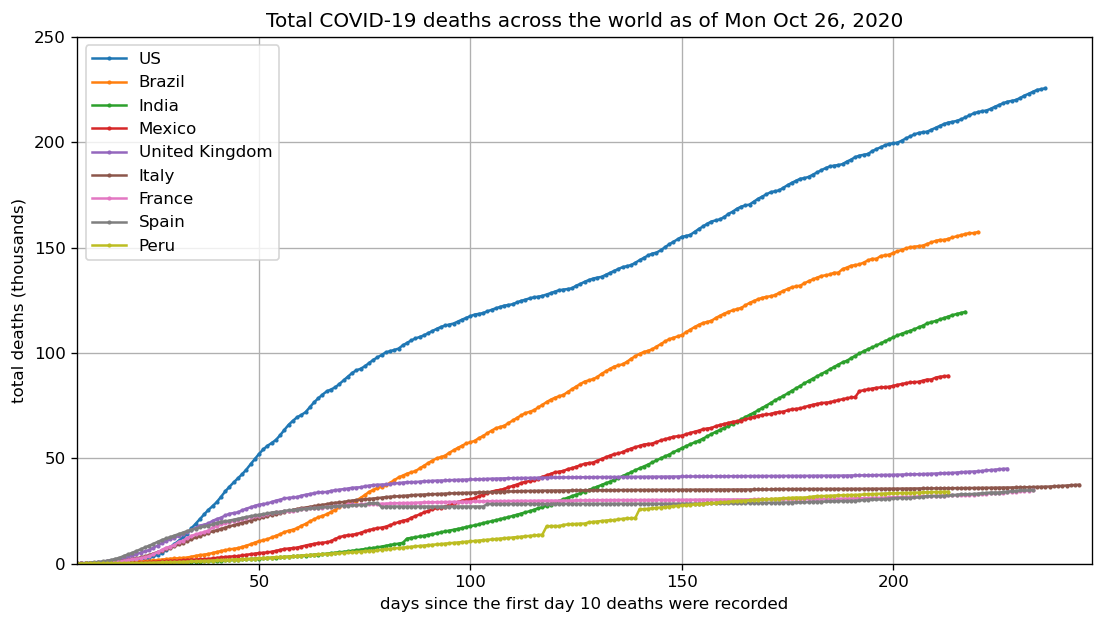

In [11]:
plt.figure(figsize=(9,5))
ax = plt.gca()

# selected countries
# countries = ['US','Italy','Spain','United Kingdom','France','Iran', 'Canada', 'Korea, South', 'Japan']
countries = deaths_sorted[:9].index
min_deaths = 10

# shift data so that index corresponds to days since min_death deaths.
shifted_data = shift_data( countries, min_deaths )
data_len = max([len(dat) for dat in shifted_data])

xmax = data_len+2

for data in shifted_data:
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot( data/1000, marker=".", label=data.name, color=color, markersize=3 )

# make plot
ax.set_title("Total COVID-19 deaths across the world as of %s" % latest_date)
ax.legend(loc="upper left")
ax.set_xlabel("days since the first day %g deaths were recorded" % min_deaths )
ax.set_ylabel("total deaths (thousands)")
ax.grid()
ax.set_xlim(7,xmax)
ax.set_ylim(ymin=0,ymax=250)


plt.tight_layout(pad=0)
plt.savefig("figures/world_total_deaths_vs_time_linear.png")